## 1. Data Preprocessing

## 1.1. Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import pprint
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer

In [2]:
import sklearn
import time
import gc
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split, GroupKFold, KFold, TimeSeriesSplit
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import datetime 
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
sns.set(color_codes=True)

In [3]:
catalog = pd.read_csv("dataset/catalog.csv",sep="|")
orders = pd.read_csv("dataset/orders.csv",sep="|")

In [4]:
print('(rows,columns) in the table catalog:'+str(catalog.shape))
print('(rows,columns) in the table orders :'+str(orders.shape))

(rows,columns) in the table catalog:(5000, 8)
(rows,columns) in the table orders :(206306, 4)


In [7]:
orders.iloc[0]

part_id                10407
order_quantity             3
date              2018-05-23
firm_id                   53
Name: 0, dtype: object

In [5]:
catalog.head()

,part_id,part_definition_id,part_product_class_id,common_part_catalog_id,preferred_supplier_id,part_family_id,stock_card_create_date,part_season
0,178,4823,190,39,1,2,2014-01-10,NaN
1,234,4823,190,39,1,2,2010-04-30,NaN
2,312,3013,360,23,1,1,2016-06-20,NaN
3,325,8726,335,39,1,2,2004-12-24,NaN
4,712,10345,555,39,1,2,2004-12-24,NaN


#### The dataset consists of two tables:
>(1) Catalog: includes the information about each part. The information consists of different id numbers and a creation date. There are 5000 unique parts therefore it is the number of rows catalog table has. (2) Orders: a record for each (day,part_id) pair's order quantities. Orders table have 206,306 rows.

#### We need to combine the data sources to create our final dataset.
To do it, we do a LEFT join from orders table to catalog table using the common part_id column, therefore not losing any row from the original catalog table.

### 1.2.3. Converting the Data to Training Format

Firstly, we convert date columns to date objects to be able toapply time-based manipulations.

Next, since the project's purpose is to predict *monthly* orders for a given automobile part, we want to convert the daily data into a monthly data by simply summing up all the order quantities grouping by month.

At the end of this manipulation, we end up with 101,932 rows and 10 columns from our initial orders table size 206,306.

In [6]:
catalog["stock_card_create_date"] = pd.to_datetime(catalog["stock_card_create_date"])
orders["date"] = pd.to_datetime(orders["date"])
orders["period"] = pd.to_datetime(orders["date"]).dt.to_period('m')
orders = orders.sort_values(["part_id","period"])
df = pd.DataFrame(orders.groupby(['period','part_id']).order_quantity.sum()).reset_index()
df = df.merge(catalog,"left","part_id")
df["time"] = df["period"].rank(method = "dense")

In [8]:
df.shape

(101932, 12)

## 1.2. Correcting & Analyzing the Data

### 1.2.1. Inserting Missing Data

When there is no order for a given month and a part, that can be a useful information as well. Since we only have orders in our training data, we can add rows with zero order quantity for the cases when there is no order.

In [7]:
period = df[["period"]].drop_duplicates().sort_values("period").reset_index(drop=True)
period["period"] = period["period"].astype("period[M]")

ids = df[['part_id', 'part_definition_id','part_product_class_id', 
            'common_part_catalog_id','preferred_supplier_id', 'part_family_id',
            'stock_card_create_date','part_season']].drop_duplicates()

period['key'] = 0
ids['key'] = 0
join = period.merge(ids, how='outer')

del join["key"], period, ids
gc.collect()

data = df
data["min_period"] = data.groupby(["part_id"])["period"].transform("min")

data = join.merge(data,"left",['part_id', 'part_definition_id','part_product_class_id', 
                               'common_part_catalog_id','preferred_supplier_id', 'part_family_id',
                               'stock_card_create_date','part_season', 'period'])

data["min_period"] = data.groupby(["part_id"])["min_period"].apply(lambda x: x.fillna(method="bfill").fillna(method="ffill"))
data["order_quantity"] = data["order_quantity"].fillna(0)
print(data.shape)

data = data[data["period"]>=data["min_period"]]
del data["min_period"]

data["time"] = data["period"].rank(method = "dense")
data['period_str']=data.period.astype(str)
print(data.shape)

(180000, 12)
(167059, 12)


After inserting rows with zero, we see that our final data will have 167,059 rows.

### 1.2.2. Exploratory Data Analysis

Since our aim is to predict monthly order quantities per automobile parts, we firstly need to check how is the *trend* in our dataset, i.e. do we see a seasonality, or stable demand. As can be seen in the figure, there is a decreasing trend in the orders. This gives us a great idea on selecting the model validation method. We need to build a time based separation for our validation data instead of a shuffled split in order to consider the decreasing trend in the orders.

In [9]:
monthly_orders = pd.DataFrame(data.groupby('period_str')['order_quantity'].sum()).reset_index()

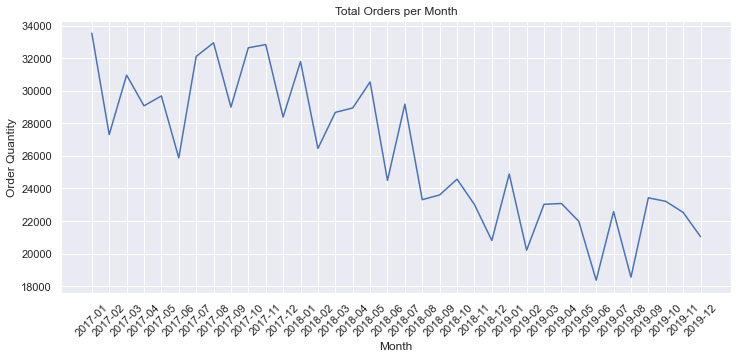

In [10]:
plt.figure(figsize=(12,5))
fig = sns.lineplot(data=monthly_orders,x='period_str',y='order_quantity')
fig.set_title('Total Orders per Month')
fig.set_xlabel('Month')
fig.set_ylabel('Order Quantity')
fig.set_xticklabels(labels=monthly_orders.period_str,rotation=45);

Next, we want to see the frequency of order quantities in order to decide whether our target is skewed either to the left or right.

Before applying bins to our data, we apply a clamp transformation as we have outliers in our data.

We cut the data into bins while setting the maximum quantity to 72. That is because after observing the frequencies, values greater than 72 can be considered as outliers.

In [11]:
data['order_quantity_bin'] = data.order_quantity.apply(lambda x: x if x<72 else 72)

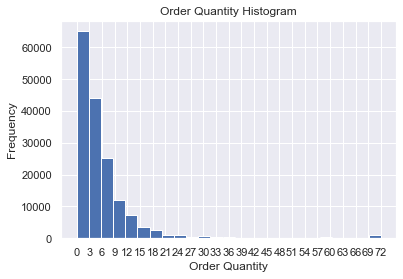

In [12]:
fig = data.order_quantity_bin.plot(
    kind='hist',
    bins=data.order_quantity_bin.nunique(),
    xticks=sorted(data.order_quantity_bin.unique()),
    title='Order Quantity Histogram');
fig.set_xlabel('Order Quantity');

As can be seen from the figure, our data is very much skewed to the left (positively skewed) with a skewness value of 4.51.

## 1.3. Generating Features 

Now that we got to know our data, we can generate features that can be useful in predicting the order quantity. In this part, we will generate time-series features and distributor firm related features.

### 1.3.1. Time Difference between Consecutive Orders

Time difference of consecutive orders by part id to represent its frequency with some stats (mean, std)

In [13]:
df["time_diff"] = df.groupby(["part_id"])["time"].diff()
time_diff_mean = df.groupby(["part_id"])["time_diff"].mean().to_dict()
time_diff_std = df.groupby(["part_id"])["time_diff"].std().to_dict()

In [14]:
data['time_diff_mean'] = data.part_id.replace(time_diff_mean)
data.time_diff_mean.fillna(data.time_diff_mean.max(),inplace=True)
data['time_diff_std'] = data.part_id.replace(time_diff_std)
data.time_diff_std.fillna(data.time_diff_std.max(),inplace=True)

### 1.3.2. Order Quantities from Last N Months

In [15]:
def sum_n_months(row, n):
    tmp = 0
    for i in range(1,(n+1)):
        x = row[f'order_quantity_lag{i}']
        if np.isnan(x)==False:
            tmp += row[f'order_quantity_lag{i}'] 
    return tmp

In [16]:
for i in [1,2,3,4,5,6]:
    data[f"order_quantity_lag{i}"] = data.groupby("part_id")["order_quantity"].shift(i)
    data[f"order_quantity_lag{i}"] = data.groupby("part_id")[f"order_quantity_lag{i}"].transform(lambda x: x.fillna(x.max()))

### 1.3.3. Rolling Mean and Standard Deviations of Lags

In [17]:
for i in [3,6]:
    data[f'order_quantity_lag{i}_mean'] = data.groupby(['part_id'])["order_quantity"].transform(lambda x: x.shift(1).rolling(i).mean())
    data[f'order_quantity_lag{i}_std'] = data.groupby(['part_id'])["order_quantity"].transform(lambda x: x.shift(1).rolling(i).std())
    data[f'order_quantity_lag{i}_sum'] = data.apply(sum_n_months,n=i,axis=1)
    data[f"order_quantity_lag{i}_mean"] = data.groupby("part_id")[f"order_quantity_lag{i}_mean"].transform(lambda x: x.fillna(x.mean()))
    data[f"order_quantity_lag{i}_std"] = data.groupby("part_id")[f"order_quantity_lag{i}_std"].transform(lambda x: x.fillna(x.mean()))

In the following table we see how order_quantity_lagN works. In each lag, we go back N months in time and retrieve the order quantity for that part.

Then for 3 months and 6 months lag, we take the total orders, their mean, and standard deviation. Since there are some Null values due to non-existent previous records, we fill the Null values with their group averages.

For example, the part with ID number 72823 has an order quantity of 6 in 2019-03. In lag-1, lag-2, and lag-3, it had 12, 0, and 18 orders, respectively. We write them in their related columns. Then, we sum 12+0+18=30 and write it to lag3_sum column. Then we take the mean of 30 which is 30/3=10 and write it to lag3_mean column. Lastly, we take the standard deviation of 12, 0, and 18 (=9.16) and write it to lag3_std column.

In [18]:
data[data.part_id==72823][['period','order_quantity',"order_quantity_lag1",'order_quantity_lag2',"order_quantity_lag3",'order_quantity_lag3_sum','order_quantity_lag3_mean','order_quantity_lag3_std']].head()

,period,order_quantity,order_quantity_lag1,order_quantity_lag2,order_quantity_lag3,order_quantity_lag3_sum,order_quantity_lag3_mean,order_quantity_lag3_std
119999,2018-12,18.0,18.0,18.0,18.0,54.0,11.2,5.580617
124999,2019-01,0.0,18.0,18.0,18.0,54.0,11.2,5.580617
129999,2019-02,12.0,0.0,18.0,18.0,36.0,11.2,5.580617
134999,2019-03,6.0,12.0,0.0,18.0,30.0,10.0,9.165151
139999,2019-04,12.0,6.0,12.0,0.0,18.0,6.0,6.000000


## 1.4. Clustering Categorical Features

Our data have 5 categorical columns which are related to parts' properties. We first look at how many unique values each column has. As a rule of thumb, we want to cluster a column if it has > 50 categories in order to reduce the probability of overfitting.

In [19]:
data[['part_definition_id','part_product_class_id','common_part_catalog_id','preferred_supplier_id','part_family_id']].nunique()

part_definition_id        1918
part_product_class_id      446
common_part_catalog_id      29
preferred_supplier_id        5
part_family_id             225
dtype: int64

As we see above, part_definition_id, part_product_class_id, and part_family_id have number of unique values greater than 50. We cluster them using KMeans algorithm and write the resultant clusters information into new columns.

### 1.4.1. Clustering: part_definition_id

In [20]:
c_pdid = data.groupby(['part_definition_id']).order_quantity_bin.agg(['mean','std'])
c_pdid['mean'] = c_pdid['mean']/data.order_quantity_bin.mean()
c_pdid['std'] = c_pdid['std']/data.order_quantity_bin.std()
kmeans = KMeans(n_clusters=6, random_state=0).fit(c_pdid)
kmeans.labels_
c_pdid["cluster"] = kmeans.labels_

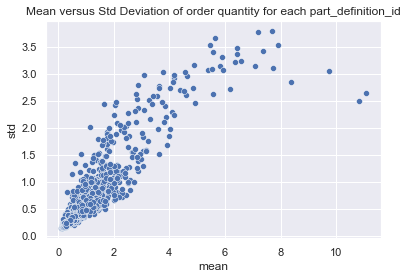

In [21]:
sns.scatterplot(data=c_pdid, x="mean", y="std")
plt.title('Mean versus Std Deviation of order quantity for each part_definition_id')
plt.show()

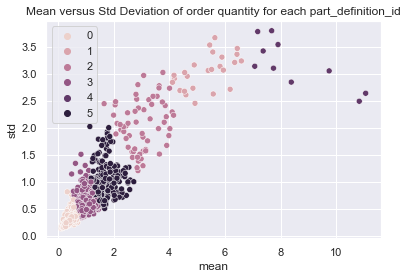

In [22]:
sns.scatterplot(data=c_pdid, x="mean", y="std",hue=c_pdid.cluster.tolist())
plt.title('Mean versus Std Deviation of order quantity for each part_definition_id')
plt.show()

### 1.4.2. Clustering: part_product_class_id

In [23]:
c_pcid = data.groupby(['part_product_class_id']).order_quantity_bin.agg(['mean','std'])
c_pcid['mean'] = c_pcid['mean']/data.order_quantity_bin.mean()
c_pcid['std'] = c_pcid['std']/data.order_quantity_bin.std()
kmeans = KMeans(n_clusters=6, random_state=0).fit(c_pcid)
kmeans.labels_
c_pcid["cluster"] = kmeans.labels_

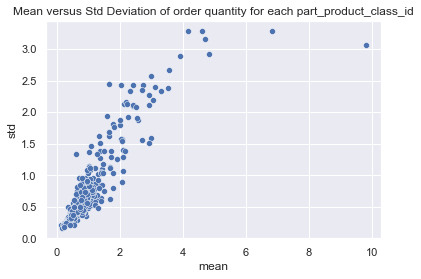

In [24]:
sns.scatterplot(data=c_pcid, x="mean", y="std")
plt.title('Mean versus Std Deviation of order quantity for each part_product_class_id')
plt.show()

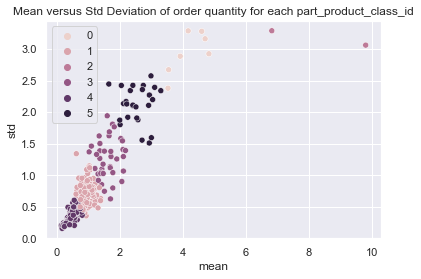

In [25]:
sns.scatterplot(data=c_pcid, x="mean", y="std",hue=c_pcid.cluster.tolist())
plt.title('Mean versus Std Deviation of order quantity for each part_product_class_id')
plt.show()

### 1.4.3. Clustering: part_family_id

In [26]:
c_pfid = data.groupby(['part_family_id']).order_quantity_bin.agg(['mean','std'])
c_pfid['mean'] = c_pfid['mean']/data.order_quantity_bin.mean()
c_pfid['std'] = c_pfid['std']/data.order_quantity_bin.std()
kmeans = KMeans(n_clusters=6, random_state=0).fit(c_pfid)
kmeans.labels_
c_pfid["cluster"] = kmeans.labels_

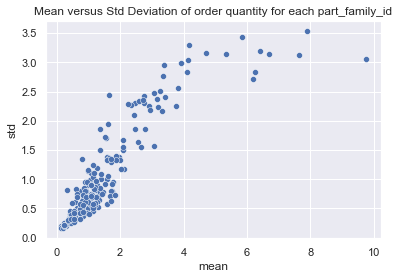

In [27]:
sns.scatterplot(data=c_pfid, x="mean", y="std")
plt.title('Mean versus Std Deviation of order quantity for each part_family_id')
plt.show()

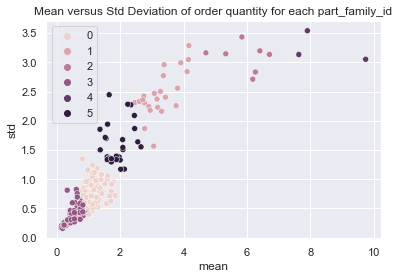

In [28]:
sns.scatterplot(data=c_pfid, x="mean", y="std",hue=c_pfid.cluster.tolist())
plt.title('Mean versus Std Deviation of order quantity for each part_family_id')
plt.show()

### 1.4.4. Applying Clusters

In [29]:
data['pdid_cluster'] = data.part_definition_id.replace(dict(zip(c_pdid.index,c_pdid.cluster)))
data['pfid_cluster'] = data.part_family_id.replace(dict(zip(c_pfid.index,c_pfid.cluster)))
data['pcid_cluster'] = data.part_product_class_id.replace(dict(zip(c_pcid.index,c_pcid.cluster)))

## 1.5. Encoding Categorical Features

We need to apply encoding to our categorical features since most Machine Learning algorithms cannot deal with categorical data. We create the transformations accordingly below.

preferred_supplier_id: We apply Binary Encoding to this column in order to get the most information out of it.

In [30]:
lb = LabelBinarizer()
lb.fit(data.preferred_supplier_id.unique())
data = pd.concat([data.reset_index(),pd.DataFrame(lb.transform(data.preferred_supplier_id),columns=['psid_binenc_1','psid_binenc_2','psid_binenc_3','psid_binenc_4','psid_binenc_5'])],axis=1)

In [31]:
psids = data.preferred_supplier_id.unique()
psids_transform = dict(zip(psids,range(len(psids))))
data['psid']=data.preferred_supplier_id.replace(psids_transform)

common_part_catalog_id: We applied a default transformation to this column as it had 29 unique values which will enlarge our data enormously if we applied binary encoding.

In [32]:
cpcids = data.common_part_catalog_id.unique()
cpcids_transform = dict(zip(cpcids,range(len(cpcids))))
data['cpcid']=data.common_part_catalog_id.replace(cpcids_transform)

## 1.6. Finalizing Training Data

Now that we inserted missing rows, corrected data types, generated features, clustered the necessary features and encoded categorical features, our data is ready for training. We export the data into training.csv and forward with modeling stage.

`
target feature: order_quantity_bin
descriptive features:
    * time_diff_mean
    * time_diff_std
    * order_quantity_lag[N] where 1 <= N <= 6
    * order_quantity_lag[N]_mean where N in (3, 6)
    * order_quantity_lag[n]_std where N in (3, 6)
    * pdid_cluster
    * pfid_cluster
    * pcid_cluster
    * psid_binenc[N] where 1 <= N <= 5
    * psid
    * cpcid
`

In [34]:
data[['period','part_id','order_quantity','order_quantity_bin', 'order_quantity_lag1', 'order_quantity_lag2',
       'order_quantity_lag3', 'order_quantity_lag4', 'order_quantity_lag5',
       'order_quantity_lag6', 'order_quantity_lag3_mean',
       'order_quantity_lag3_std', 'order_quantity_lag3_sum',
       'order_quantity_lag6_mean', 'order_quantity_lag6_std',
       'order_quantity_lag6_sum', 'pdid_cluster', 'pfid_cluster',
       'pcid_cluster', 'psid_binenc_1', 'psid_binenc_2', 'psid_binenc_3',
       'psid_binenc_4', 'psid_binenc_5', 'cpcid', 'time_diff_mean','time',
       'time_diff_std']].shape

(167059, 28)

In [33]:
data[['period','part_id','order_quantity','order_quantity_bin', 'order_quantity_lag1', 'order_quantity_lag2',
       'order_quantity_lag3', 'order_quantity_lag4', 'order_quantity_lag5',
       'order_quantity_lag6', 'order_quantity_lag3_mean',
       'order_quantity_lag3_std', 'order_quantity_lag3_sum',
       'order_quantity_lag6_mean', 'order_quantity_lag6_std',
       'order_quantity_lag6_sum', 'pdid_cluster', 'pfid_cluster',
       'pcid_cluster', 'psid_binenc_1', 'psid_binenc_2', 'psid_binenc_3',
       'psid_binenc_4', 'psid_binenc_5', 'cpcid', 'time_diff_mean','time',
       'time_diff_std']].to_pickle('dataset/train_fillna_max.pkl')